In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt

## Privacy and Noise

PyDP provides a set of ε-differentially private algorithms, which can be used to produce aggregate statistics over numeric data sets containing private or sensitive information.

One of the most fundamental strategies for preserving privacy is adding noise. In other words, before reporting a result from your database, you'll add a random number to it. An attacker won't be able to know exactly how much of the final result is the real answer and how much is random. The idea is kind of like scribbling over a document with a marker to hide the sensitive information underneath.

But how exactly do you choose that random number? More technically, from what distribution will it be drawn?

The most common choice is the [Laplace distribution](https://en.wikipedia.org/wiki/Laplace_distribution) because it works well with the privacy parameter ε. This notebook is dedicated to exploring the Laplace distribution: what it is and why it's used for differential privacy.

## Exponential Distribution

The Laplace distribution can be thought of as two exponential distributions back-to-back so let's start by looking at the exponential distribution. It can be defined as

$ f(x) = e^{-x} $

When x is zero, f(x) is one, and the bigger x gets the closer to zero the output will be. Typically this is only defined for x >= 0. It looks like this:

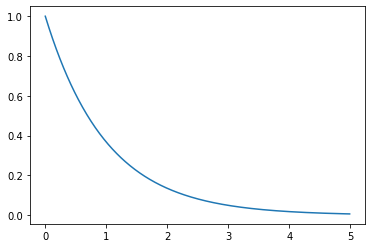

In [3]:
x = np.arange(0,5,.01)
plt.plot(x, np.exp(-x));

## Laplace

To go from the exponential distribution to the Laplace distribution you take the absolute value of x and expand the range to include negative numbers.

In [4]:
def simple_laplace(x):
    return np.exp(-np.abs(x))

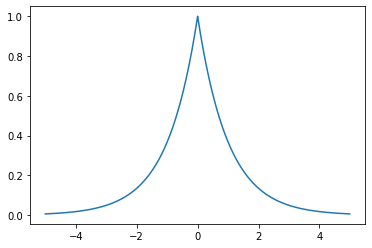

In [5]:
x = np.arange(-5,5,.01)
plt.plot(x, simple_laplace(x));

In the context of privacy, the spike in the middle of the distribution means you're relatively likely to choose a number close to zero, and therefore report a result close to the actual result from the database. However, there's a  chance you could choose a bigger number, so an attacker can't be completely certain the result they're seeing is close to the real result.

What if you wanted to adjust the distribution to make it more or less likely to report something close to the real result? You can do that by introducing a scaling parameter.

The Laplace is typically defined with two additional parameters, μ and b:

$f(x\mid \mu ,b)={\frac  {1}{2b}}\exp \left(-{\frac  {|x-\mu |}{b}}\right)\,\!$

μ is the mean, in other words the center, or the pointy bit. In the context of differential privacy, this would be the real result from the database, i.e., what you would report if you added zero noise.

b is the scaling parameter. Increasing it "flattens out" the graph so that the tails account for relatively more of the total. Increasing it gives you more privacy, because by flattening out the graph you make it more likely to choose a high value for the noise, which means an attacker can be less certain that the reported result is close to the true result.

You can try different values for μ and b and see how they affect the graph below.

In [6]:
def laplace(x, μ, b):
    return 1 / (2 * b) * np.exp(-np.abs(x - μ) / b)

def plot_laplace(x, μ, b):
    plt.plot(x, laplace(x, μ, b), label="μ={}, b={}".format(μ, b))

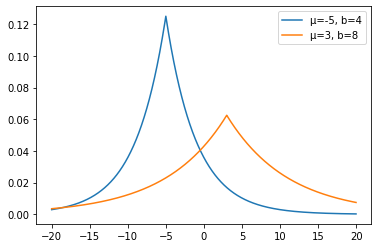

In [7]:
x = np.arange(-20, 20, 0.01)
plot_laplace(x, -5, 4)
plot_laplace(x, 3, 8)
plt.legend();

## Why Laplace?

In [ε-differential privacy](https://en.wikipedia.org/wiki/Differential_privacy#%CE%B5-differential_privacy), ε is the parameter that determines how much privacy loss is acceptable. Specifically, the *probability* that a single user was in the database that produced the result must be no more than e<sup>ε</sup> *times* the probability that they weren't.

That definition is pretty confusing! We won't be going deep into the workings of differential privacy in this notebook, but if you're interested, check out [this blog post](https://desfontain.es/privacy/differential-privacy-in-more-detail.html) to learn more.

The Laplace distribution plays nicely with ε because setting the b parameter in the Laplace distribution as 1/ε ensures that ε-differential privacy will be maintained. Why? Well basically, the math works out. Let's see an example with some actual numbers.

Suppose you've chosen an ε of 0.5 and you do some operation on your database where you report a result of 100. How sure could an attacker be that this is the real value?


In [8]:
reported_value = 100
ε = 0.5

Put yourself in the attacker's shoes. You know that 100 was reported but you don't know if it's the real value. Each potential real value gives rise to a distribution of possible reported values. For each underlying value, you can figure out how likely it would be to lead to the reported result. You would then need to ask yourself, "How likely is it that the number I'm seeing came from each of these distributions?" To satisfy ε differential privacy, it must be no more than e<sup>ε</sup> times as likely that the answer came from one distribution compared to another.

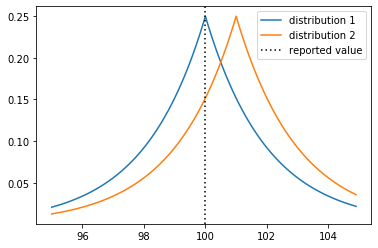

In [9]:
x = np.arange(95, 105, 0.1)
dist1 = laplace(x, reported_value, 1/ε)
dist2 = laplace(x, reported_value + 1, 1/ε)
plt.plot(x, dist1, label="distribution 1")
plt.plot(x, dist2, label="distribution 2")
plt.axvline(x=reported_value, c='black', dashes=(1,2), label="reported value")
plt.legend()

In this graph the dotted line represents the reported value, and where the solid line intersects the dotted line is the chance that the value would be reported for that distribution.

In this case it's more likely that the result came from distribution 1, but there is still a chance it came from distribution 2. Let's look at the probabilities that the answer came from each distribution.

In [10]:
p1 = laplace(reported_value, reported_value, 1/ε)
p2 = laplace(reported_value, reported_value + 1, 1/ε)
p1, p2

(0.25, 0.15163266492815836)

According to the definition of ε-differential privacy, these should not differ by a factor of more than e<sup>ε</sup>. The idea is that the more different they are, the more certain an attacker could be about which one is real. If the probabilities are very different, the attacker could be pretty sure about the real data; if they're relatively close, the attacker couldn't be very confident. By setting a limit on how much they can differ, determined by ε, you're putting a cap on how certain an attacker could be about the real data, and thus how much your users' privacy could be compromised.

In [11]:
p1, p2 * np.exp(ε)

(0.25, 0.25)

Using the Laplace distribution allows you to meet the requirement exactly.

## Conclusion

To recap:

* You make data private by adding noise.

* The Laplace distribution is constructed by stitching together two exponential distributions.

* The Laplace distribution makes it easy for you to satisfy the requirement of ε differential privacy by setting the b parameter to 1/ε.